# Determining the lightcurves of stellar clusters

## Introduction

This notebook is intended to be the same as the _cluster_lightcurves_ notebook except the clusters are analyzed in series, not in parallel, saving memory.

Its purpose is to create a mask encapsulating the sky pixels in each of the TPFs of certain clusters clusters. I did this by defining a range of fluxes and dumping all the pixels whose flux at the middle-most cadence is within that range into the sky mask. The trick is determining this range.

The lower limit of the range is easy. Sky pixels can be as dark as they want, so we set that limit near zero. However, near the edges of some sectors, there are unused pixels which capture no light. Therefore, we set the lower limit to just above zero: ten in this case.

The upper limit of the range is harder to define. To make it easier to think about, I chose some percentile $n$ and set the upper limit of the sky pixel flux range equal to the value of the $n$th flux percentile. For example, if $n=80\%$, then the brightest sky pixel will be brighter than 80\% of the pixels in the entire image. But I still need to choose $n$.

I did some tests and determined that $n$ should be about 80-90\%, but it depends on how many stars there are in the cluster. To get a handle on this, I created an algorithm to count the number of pixels whose fluxes were greater than their neighbors &mdash; maxima &mdash; in the middle-most cadence. The number of maxima will not quite be the number of stars, but hopefully it is proportional to it. If so, then we can set $n$ by this formula:

$n$ = 100\% - `SCALE_FACTOR` * (number of maxima) / (number of pixels that are either sky or star) * 100\%

where `SCALE_FACTOR` is the same for all the clusters and can be set manually to ensure that $n$ is always about 80-90\%. In other words, it is the proportionality constant relating the number of stars and the number of pixel maxima.

Note: More specifically, a pixel counts as a maximum if it its flux value in the middle-most cadence is greater than the fluxes of the four pixels above, below, to the left, and to the right.

#### Next steps:
- I want to choose background pixels based on the average over all cadences, not just the middle-most cadence.
- I need to check my maximum-counter algorithm.
- I want to try different `SCALE_FACTOR` values.
- It would be great if I could change my maximum function to be less crude &mdash; maybe I could make it good enough so that `SCALE_FACTOR` can be set equal to one.

## Code

I start by declaring default variables and loading modules. You can change `CLUSTERS` to change which clusters to run the code for, and `NUMBER_PCA_COMPONENTS` for the `lightkurve` regression algorithm.

In [1]:
%matplotlib inline
import lightkurve as lk
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import math

#CLUSTERS = ["NGC 752", "NGC 6231", "NGC 3532"]
CLUSTERS = ["M34", "M7", "NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532", "Collinder 140", "Omega Cen", "47 Tuc", "NGC 6752"]
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.78449002, 9.93415587), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113", "-31.85"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
NUMBER_PCA_COMPONENTS = 5

SCALE_FACTOR = 2
LOWER_LIMIT = 10

Now I define the function that can count the number of maxima in a 180 x 180 sized image. Remember, a pixel counts as a maximum if it its flux value in the middle-most cadence is greater than the fluxes of the four pixels above, below, to the left, and to the right.

In [2]:
def countMaxima(data):
    stars = 0
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = data[x][y-1] if (y > 0 and not np.isnan(data[x][y-1])) else 0
            down = data[x][y+1] if (y < data.shape[1]-1 and not np.isnan(data[x][y+1])) else 0
            left = data[x-1][y] if (x > 0 and not np.isnan(data[x-1][y])) else 0
            right = data[x+1][y] if (x < data.shape[0]-1 and not np.isnan(data[x+1][y])) else 0
            if b > max(up, down, left, right):
                stars += 1
    return stars

In order to load these huge images without crashing the computer, I have to load each cluster and delete its data before loading the next. So I'm defining a class with all the methods required to analyze and display the data, and I'll create and delete the class in series for each cluster.

In [3]:
tpfs = [0]*len(CLUSTERS)

class Cluster:
    def __init__(self, name):
        self.name = name
        self.tpf = 0
        
        foundLocal = False
        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if COORDS[name][0] == float(file.split("_")[-4]): # Confirm RA
                    if COORDS[name][1] == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                        foundLocal = True
                        break
        if not foundLocal:
            search = lk.search_tesscut(name)
            char = ""
            if len(search) != 1: char = "s"
            print("{0} has {1} result{2}.".format(self.name, len(search), char))
            self.tpf = search[0].download(cutout_size=180)
            
        self.frame = self.tpf.shape[0] // 2
        self.image = self.tpf[self.frame].flux.reshape((180, 180))
            
    def displayTPF(self):
        p = self.tpf.plot(frame=self.frame)
        p.set_title(self.name)
        
    def displayHist(self):
        brightnessData = self.image.reshape(180*180)
        mean = np.mean(brightnessData)
        lower_limit = 0
        upper_limit = int(2 * mean)
        brightnessData = brightnessData[np.where((brightnessData >= lower_limit) & (brightnessData <= upper_limit))]

        # Draw field
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
        self.tpf.plot(ax=ax1, frame=self.frame)
        ax1.set_title(self.name)

        # Make distribution
        x = np.arange(start=0, stop=upper_limit, step=int(upper_limit/100))
        shape = norm.fit(brightnessData)
        y = np.array([distribution(k, (upper_limit - lower_limit) / 100, shape) for k in x])

        # draw histogram and distribution
        ax2.hist(brightnessData, bins=100)
        ax2.axvline(mean, color='k')
        ax2.plot(x, y, color='r', zorder=2)
        
    def getMasks(self):
        numMaxima = countMaxima(self.image)
        notNanMask = ~np.isnan(self.image)
        notEdgeMask = self.image > LOWER_LIMIT
        numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
            # are not nan and are greater than LOWER_LIMIT.
        n = 100 - SCALE_FACTOR * numMaxima / numPixels * 100
        upperLimit = np.nanpercentile(self.image, n)# Upper limit of the sky pixel flux range
        print("{0} maxima: {1} / {2} = {3}%. n={4}".format(self.name, numMaxima, numPixels, numMaxima / numPixels*100, n))
        
        self.skyMask = ((self.image >= LOWER_LIMIT) & # Exclude edge pixels
            (self.image <= upperLimit)).reshape(180, 180)
        self.starMask = ((self.image > upperLimit)).reshape(180, 180)
        
    def displayMasks(self):
        skyFlux = np.ma.array(self.image, mask=~self.skyMask).reshape(180, 180).filled(fill_value=0)
        starFlux = np.ma.array(self.image, mask=~self.starMask).reshape(180, 180).filled(fill_value=0)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
        ax1.imshow(skyFlux, vmin=0, vmax=np.nanpercentile(self.image, 95))
        ax1.set_title(self.name + " sky mask values")
        ax2.imshow(starFlux, vmin=0, vmax=np.nanpercentile(self.image, 95))
        ax2.set_title(self.name + " star mask values")
        
    def generateLightcurve(self):
        self.lc = self.tpf.to_lightcurve(aperture_mask=self.starMask)

        regressor = self.tpf.flux[:, self.skyMask]# The regressor is the inverse of the aperture

        dm = lk.DesignMatrix(regressor, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
        corrector = lk.RegressionCorrector(self.lc)
        self.correctedLC = corrector.correct(dm)
        
    def displayLightcurves(self):
        plot = self.lc.plot(marker='.', ls='none', color='r');# This is where you would flatten the curves
        plot2 = self.correctedLC.plot(marker='.', ls='none', color='b');# This is where you would flatten the curves
        plot.set_title("TESS 2-min lightcurve for {0}.".format(self.name));
        plot2.set_title("TESS 2-min lightcurve for {0}, corrected.".format(self.name));

/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater


M34 maxima: 1024 / 18000 = 5.688888888888889%. n=88.62222222222222


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater


M7 maxima: 820 / 11700 = 7.0085470085470085%. n=85.98290598290598
NGC 752 maxima: 1448 / 32400 = 4.469135802469136%. n=91.06172839506172
IC 2391 maxima: 2103 / 32400 = 6.490740740740741%. n=87.01851851851852
NGC 6231 maxima: 2634 / 32400 = 8.12962962962963%. n=83.74074074074073


Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 105, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

Lambda Orionis has 1 result.
Lambda Orionis maxima: 1686 / 32400 = 5.203703703703703%. n=89.5925925925926
NGC 3532 maxima: 1937 / 32400 = 5.978395061728395%. n=88.04320987654322


/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


Collinder 140 has 1 result.


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Collinder 140 maxima: 1095 / 22500 = 4.866666666666666%. n=90.26666666666667


/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


Omega Cen maxima: 2246 / 32400 = 6.932098765432099%. n=86.1358024691358


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

47 Tuc maxima: 2318 / 32400 = 7.154320987654321%. n=85.69135802469135


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

NGC 6752 maxima: 194 / 2700 = 7.185185185185185%. n=85.62962962962963


/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


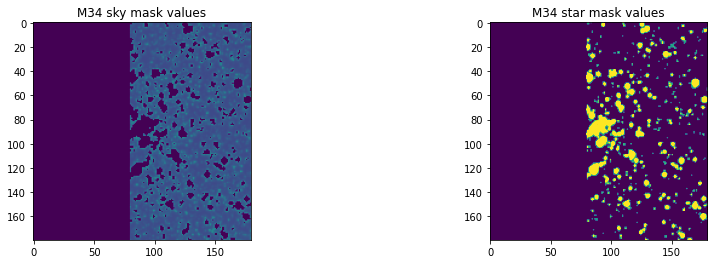

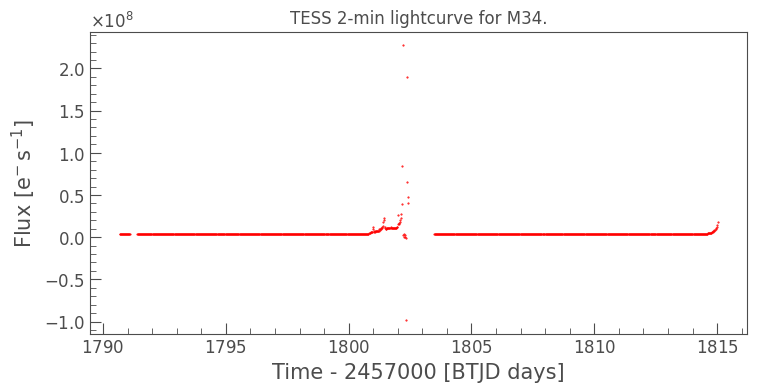

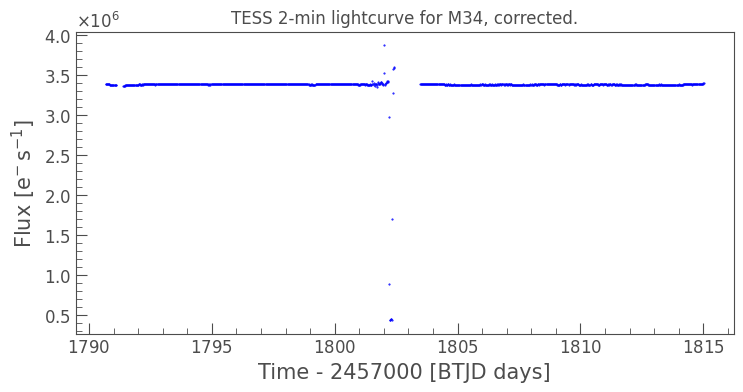

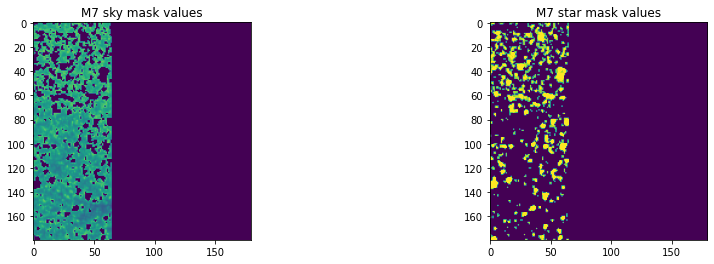

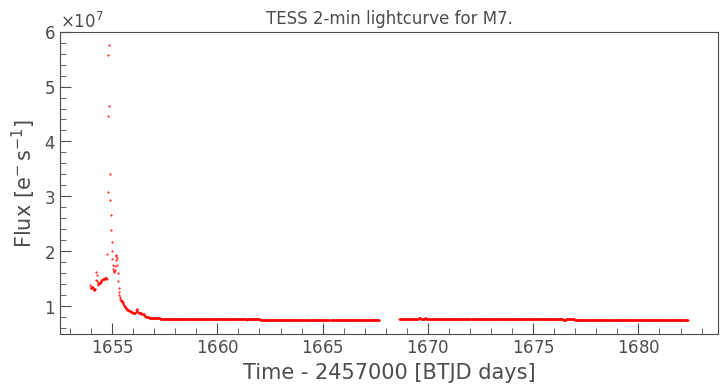

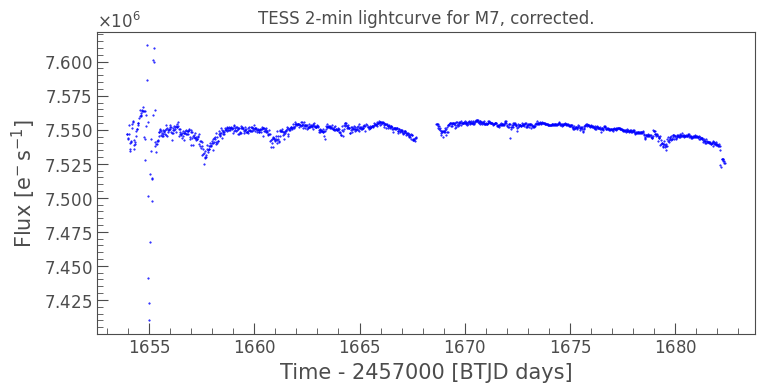

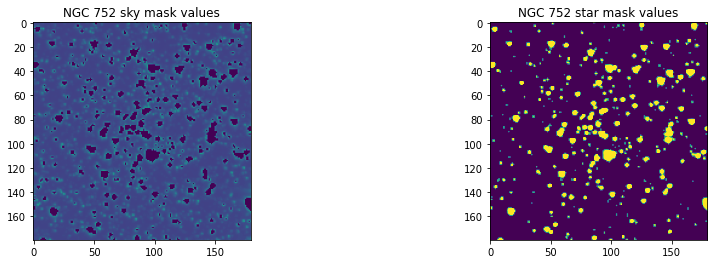

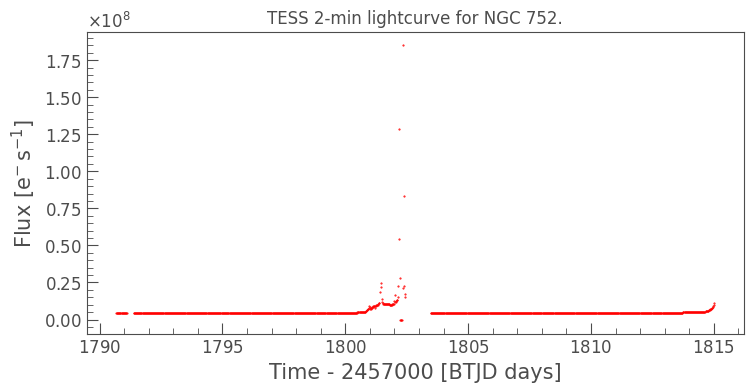

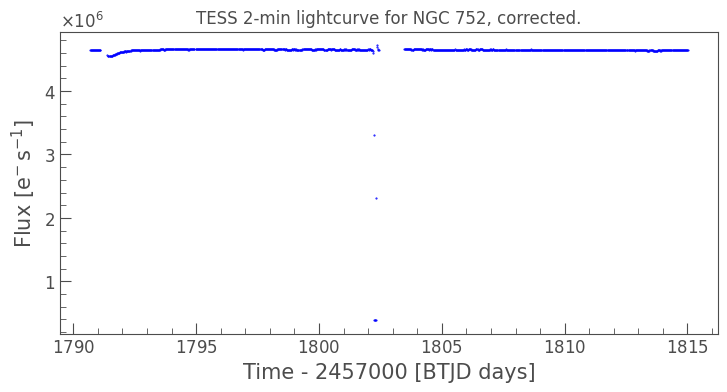

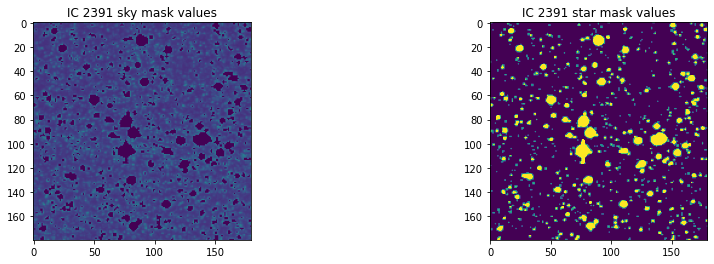

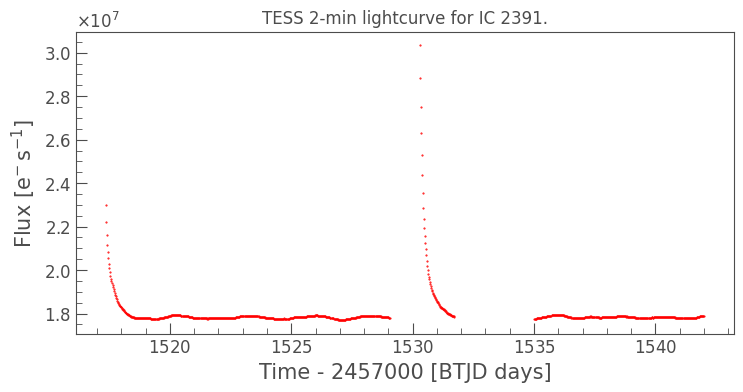

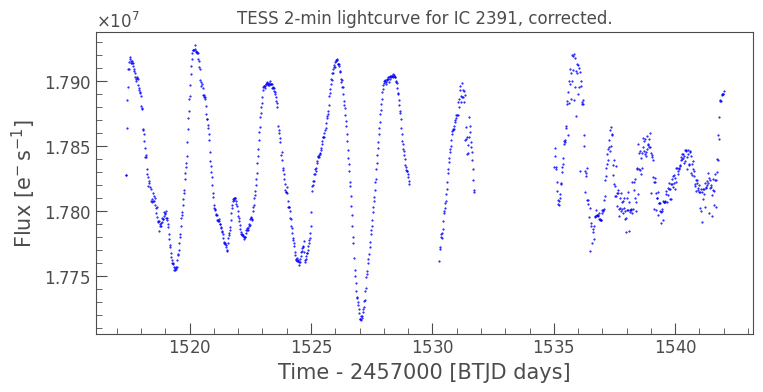

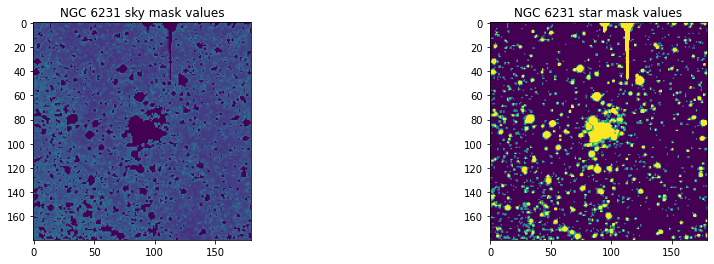

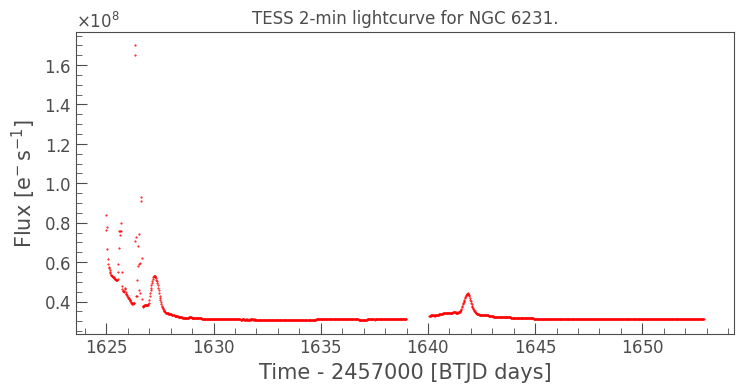

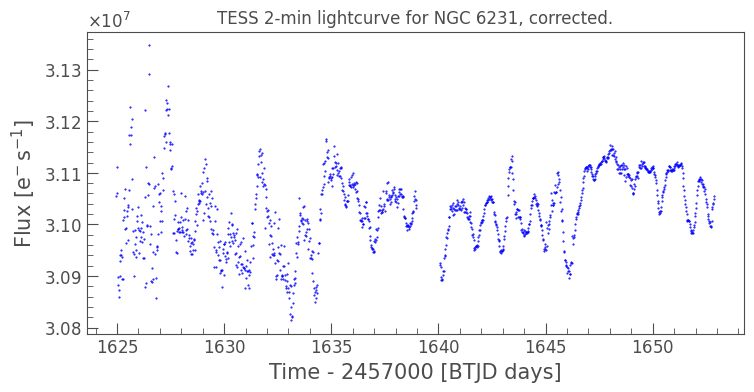

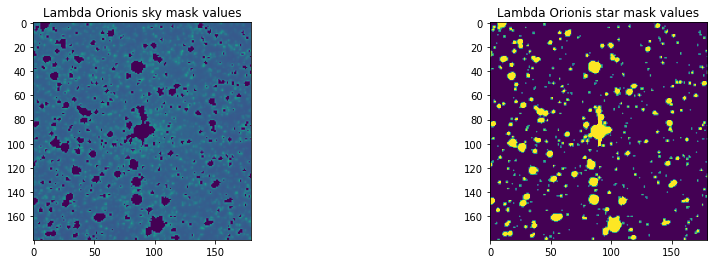

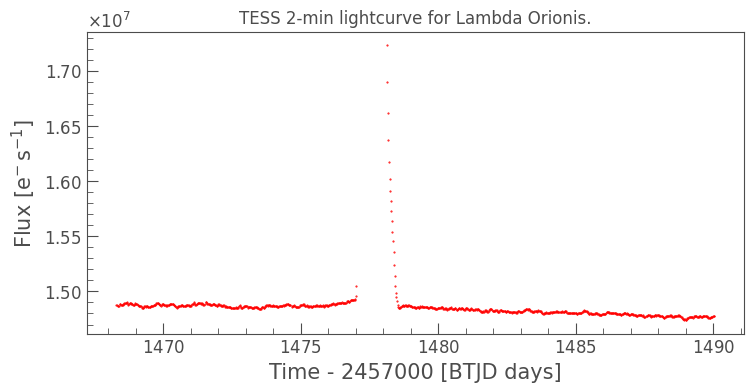

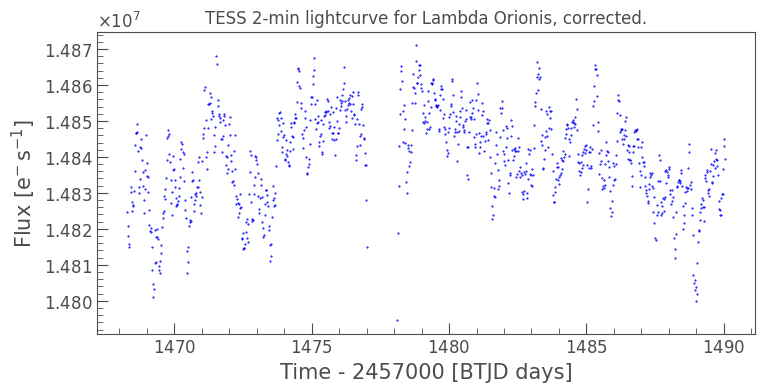

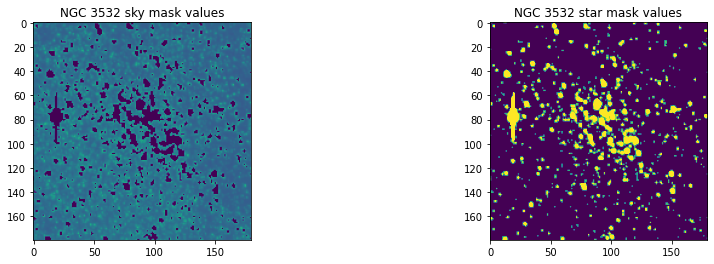

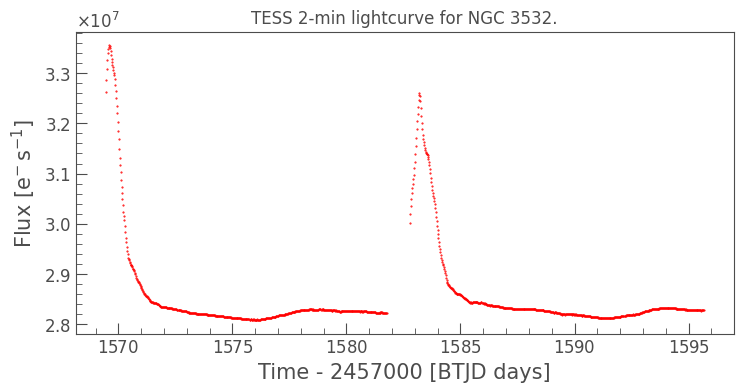

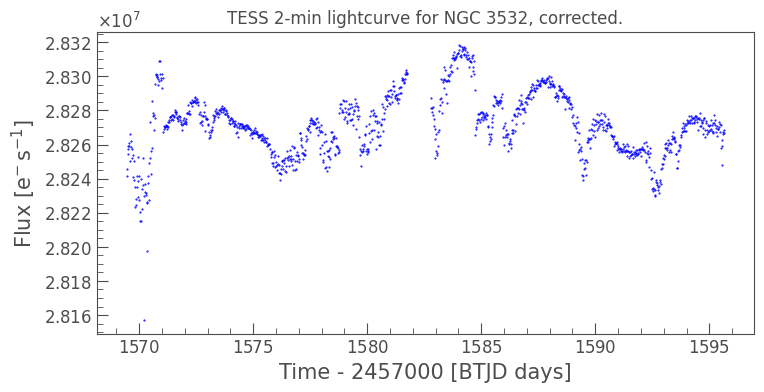

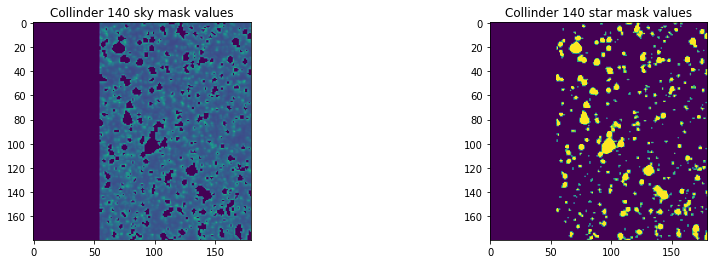

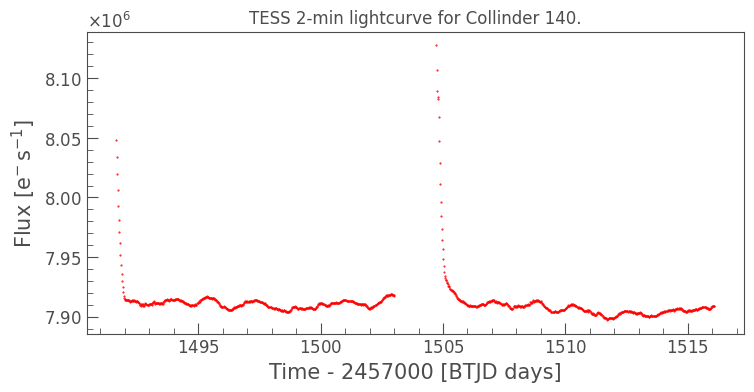

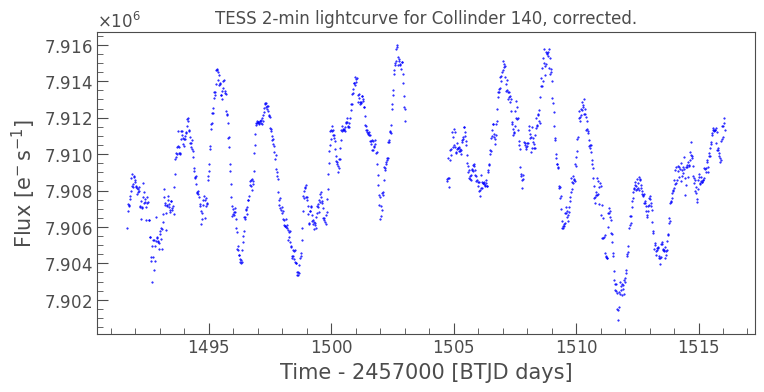

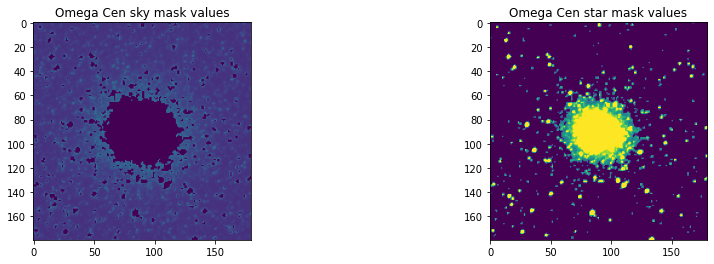

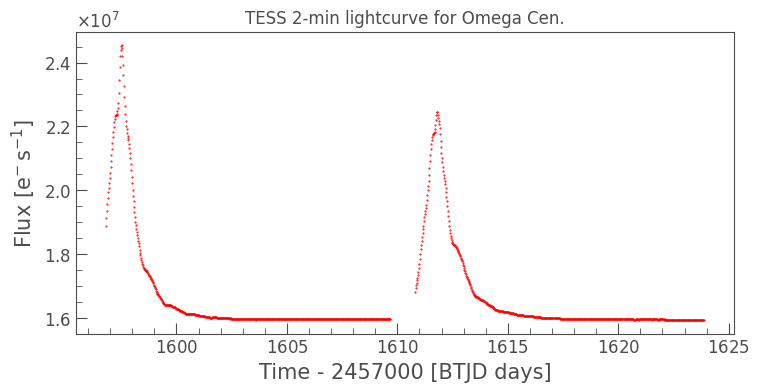

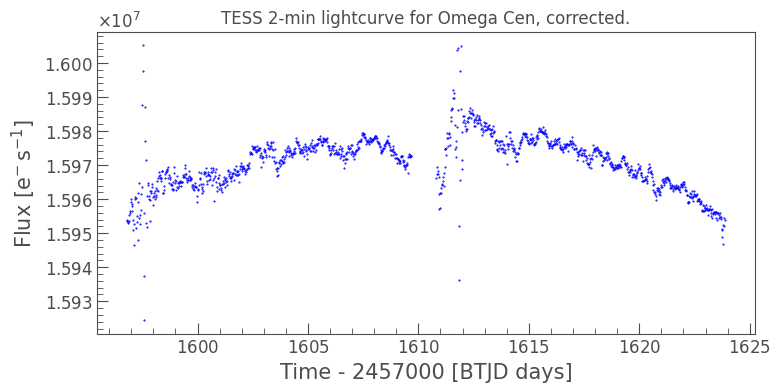

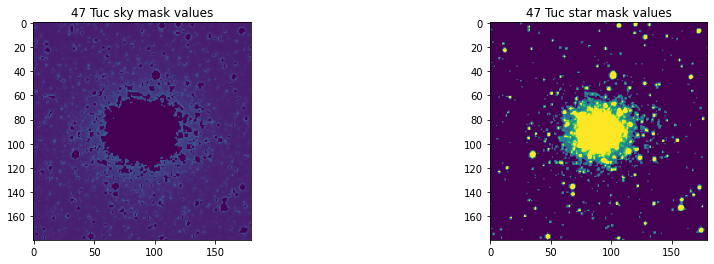

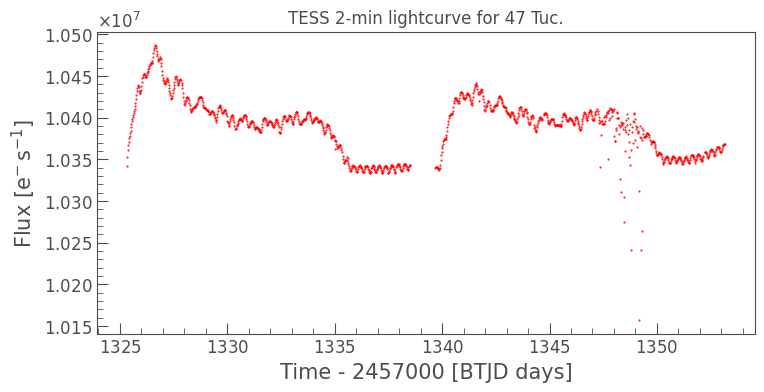

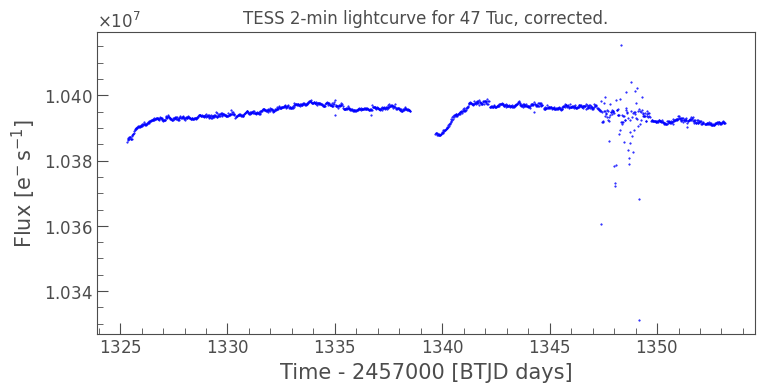

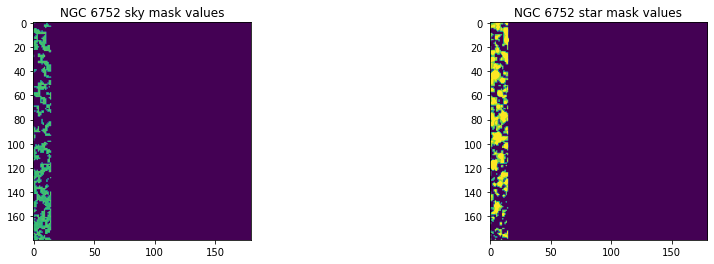

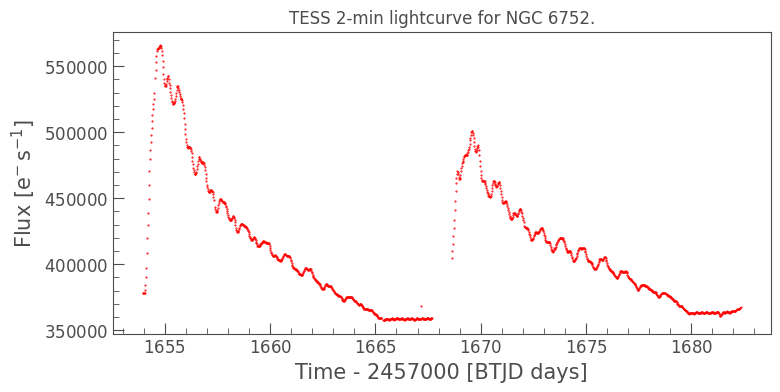

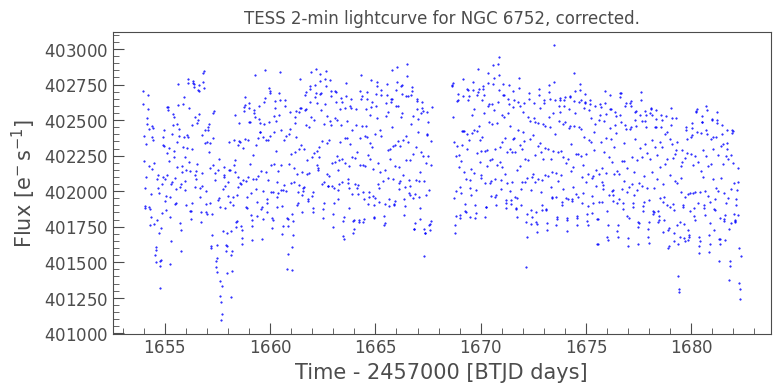

In [4]:
UPPER_LIMIT_METHOD = 4

for c in CLUSTERS:
    cl = Cluster(c)
    #cl.displayTPF()
    #cl.displayHist()
    cl.getMasks()
    cl.displayMasks()
    cl.generateLightcurve()
    cl.displayLightcurves()

To clean up the lightcurves, you can change `NUMBER_PCA_COMPONENTS` and `SCALE_FACTOR`.